## Exploration of Original GazeCapture Dataset
Specifically on subject 00002 (from `data/converted_00002`)

### Imports and Helper Functions

In [1]:
from comet_ml import Experiment
import torch
import os
import random
import numpy as np
import matplotlib.image as mpimg

from PIL import Image
from glob import glob
from tqdm import tqdm, trange
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import json
import pytorch_lightning as pl

from pytorch_lightning.loggers import CometLogger

In [2]:
import sys
#sys.path.insert(0, './gaze-track-main/Experiments')
sys.path.insert(0, '../src/pred/')
sys.path.insert(1, '../src/datasets')

from model import gazetrack_model
from gazetrack_data import gazetrack_dataset

In [3]:
import colorsys
def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

def euc(a, b):
    return np.sqrt(np.sum(np.square(a - b), axis=1))

def plot_pts(fname, gt, preds, pts, c, title):
    cols = np.zeros((len(gt),3))
    for i in range(len(pts)):
        cols[np.where(np.all(gt==pts[i],axis=1))] = c[i]
    
    plt.figure(figsize=(12,12))
    plt.title(title)
    plt.grid(color='gray', linestyle='dashed')
    plt.scatter(0, 0, marker='*', s=200)
    plt.scatter(preds[:,0], preds[:,1], c=cols, s=10)
    plt.scatter(gt[:,0], gt[:,1], c=cols, marker='+', s=200)
    plt.xlabel('distance from the camera at origin in x direction (cm)')
    plt.ylabel('distance from the camera at origin in y direction (cm)')
    plt.axis('equal')

### Visualization for Subject 00002

{'device': 'iPhone 6', 'screen_h': 568, 'screen_w': 320, 'face_valid': 1, 'face_x': 38, 'face_y': 230, 'face_w': 344, 'face_h': 344, 'leye_x': 205, 'leye_y': 309, 'leye_w': 103, 'leye_h': 103, 'reye_x': 71, 'reye_y': 319, 'reye_w': 103, 'reye_h': 103, 'dot_xcam': 1.064, 'dot_y_cam': -6.0055, 'dot_x_pix': 160, 'dot_y_pix': 284, 'reye_x1': 124, 'reye_y1': 380, 'reye_x2': 175, 'reye_y2': 371, 'leye_x1': 250, 'leye_y1': 367, 'leye_x2': 302, 'leye_y2': 370}


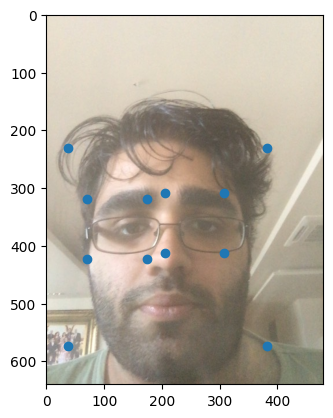

In [11]:
img_path = os.path.abspath("../data/converted_00002/train/images/00002__00000.jpg")
meta_path = os.path.abspath("../data/converted_00002/train/meta/00002__00000.json")

with open(meta_path) as f:
    meta = json.load(f)
    print(meta)

def makeBoundingBox(x, y, w, h): 
    return [(x, y), (x+w, y), (x+w, y+h), (x, y+h)]

face_bounding_box = makeBoundingBox(meta['face_x'], meta['face_y'], meta['face_w'], meta['face_h'])
leye_bounding_box = makeBoundingBox(meta['leye_x'], meta['leye_y'], meta['leye_w'], meta['leye_h'])
reye_bounding_box = makeBoundingBox(meta['reye_x'], meta['reye_y'], meta['reye_w'], meta['reye_h'])

%matplotlib inline

img = mpimg.imread(img_path)
face_x, face_y = zip(*face_bounding_box)
leye_x, leye_y = zip(*leye_bounding_box)
reye_x, reye_y = zip(*reye_bounding_box)
x = face_x + leye_x + reye_x
y = face_y + leye_y + reye_y

plt.imshow(img)
plt.scatter(x, y)

### Load model and weights; test model on subject 00002

In [16]:
f = '../data/converted_data/converted_00002/train/images/'
weight_file = '../checkpoints/checkpoint.ckpt'
# weight_file = "../checkpoints/GoogleCheckpoint_GoogleSplit.ckpt"

print(weight_file)
print('Number of test files: ', len(glob(f+"*.jpg")))

../checkpoints/checkpoint.ckpt
Number of test files:  32


In [18]:
# accounts for CUDA not available
model = gazetrack_model()
if(torch.cuda.is_available()):
    dev = torch.device('cuda:0')
else:
    dev = torch.device('cpu')
    
w = torch.load(weight_file, map_location=dev)['state_dict']
model.load_state_dict(w)
model.to(dev)
model.eval()

preds, gt, ors = [], [], []
ctr = 1
test_dataset = gazetrack_dataset(f, phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=512, num_workers=10, pin_memory=False, shuffle=False,)

for j in tqdm(test_dataloader):
    leye, reye, kps, target, ori = j[1].to(dev), j[2].to(dev), j[3].to(dev), j[4].to(dev), j[-1]
    # print("leye type: ", type(leye), " leye: ", leye)
    # print("reye type: ", type(reye), " reye: ", reye)
    # print("kps type: ", type(kps), " kps: ", kps)
    print("leye type: ", type(leye), " shape: ", leye.shape)
    print("reye type: ", type(reye), " shape: ", reye.shape)
    print("kps type: ", type(kps), " shape: ", kps.shape)
    
    with torch.no_grad():
        pred = model(leye, reye, kps)
    pred = pred.detach().cpu().numpy()
    preds.extend(pred)
    ors.extend(ori)
    
    gt.extend(target.detach().cpu().numpy())
    
preds = np.array(preds)
gt = np.array(gt)
ors = np.array(ors)
dist = euc(preds, gt)
print("Mean Euclidean Distance: ", dist.mean())

Num files for test = 32


100%|██████████| 1/1 [00:06<00:00,  6.43s/it]

leye type:  <class 'torch.Tensor'>  shape:  torch.Size([32, 3, 128, 128])
reye type:  <class 'torch.Tensor'>  shape:  torch.Size([32, 3, 128, 128])
kps type:  <class 'torch.Tensor'>  shape:  torch.Size([32, 11])


100%|██████████| 1/1 [00:11<00:00, 11.44s/it]

Mean Euclidean Distance:  2.9702492


In [9]:
preds.shape

(32, 2)

In [19]:
print("Portrait orientation: ", np.mean(dist[np.where(ors==2)]))
print("Landscape, with home button on the right: ", np.mean(dist[np.where(ors==1)]))
print("Landscape, with home button on the left: ", np.mean(dist[np.where(ors==0)]))

Portrait orientation:  2.9677258
Landscape, with home button on the right:  nan
Landscape, with home button on the left:  nan


(-1.3052552700042725,
 3.4750360012054444,
 -10.999015760421752,
 0.5237626552581788)

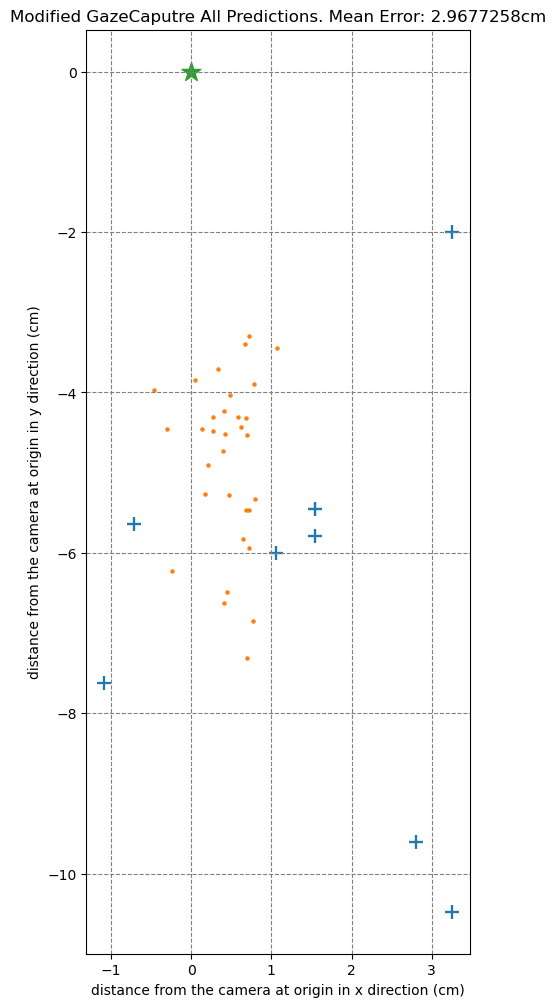

In [20]:
import random

c = get_colors(30)
random.shuffle(c)
    
plt.figure(figsize=(12,12))
plt.title('Modified GazeCaputre All Predictions. Mean Error: '+str(dist.mean())+"cm")
plt.grid(color='gray', linestyle='dashed')

plt.scatter(gt[:,0], gt[:,1],  marker='+', s=100)
plt.scatter(preds[:,0], preds[:,1], s=5)
plt.scatter(0, 0, marker='*', s=200)

plt.xlabel('distance from the camera at origin in x direction (cm)')
plt.ylabel('distance from the camera at origin in y direction (cm)')
plt.axis('scaled')

### Subject 00002 Error Traces

In [21]:
all_files = glob(f+"/*.jpg")
all_files = [i[:-10] for i in all_files]
files = np.unique(all_files)
print('Found ', len(all_files), ' images from ', len(files), ' subjects.')

fnames = []
nums = []
for i in tqdm(files):
    fnames.append(i)
    nums.append(len(glob(i+"*.jpg")))
fnames = np.array(fnames)
nums = np.array(nums)
ids = np.argsort(nums)
ids = ids[::-1]
fnames_sorted = fnames[ids]
nums_sorted = nums[ids]
files = fnames_sorted.copy()
nums_sorted[0], nums_sorted[-1], sum(nums_sorted)

Found  32  images from  1  subjects.


100%|██████████| 1/1 [00:00<00:00, 1455.34it/s]


(32, 32, 32)

In [22]:
total_test = {}

for idx in tqdm(range(len(files))):    
    preds, gt = [], []
    ctr = 1
    f = files[idx]
    test_dataset = gazetrack_dataset(f, phase='test')
    test_dataloader = DataLoader(test_dataset, batch_size=100, num_workers=10, pin_memory=False, shuffle=False,)

    for j in test_dataloader:
        leye, reye, kps, target = j[1].to(dev), j[2].to(dev), j[3].to(dev), j[4].to(dev)

        with torch.no_grad():
            pred = model(leye, reye, kps)
        pred = pred.detach().cpu().numpy()
        preds.extend(pred)  

        gt.extend(target.detach().cpu().numpy())

    preds = np.array(preds)
    pts = np.unique(gt, axis=0)

    gt = np.array(gt)
    dist = euc(preds, gt)
    total_test[f] = [dist, gt, preds, pts]

  0%|          | 0/1 [00:00<?, ?it/s]

Num files for test = 32


100%|██████████| 1/1 [00:07<00:00,  7.67s/it]


Text(0, 0.5, 'Mean Euclidean Distance')

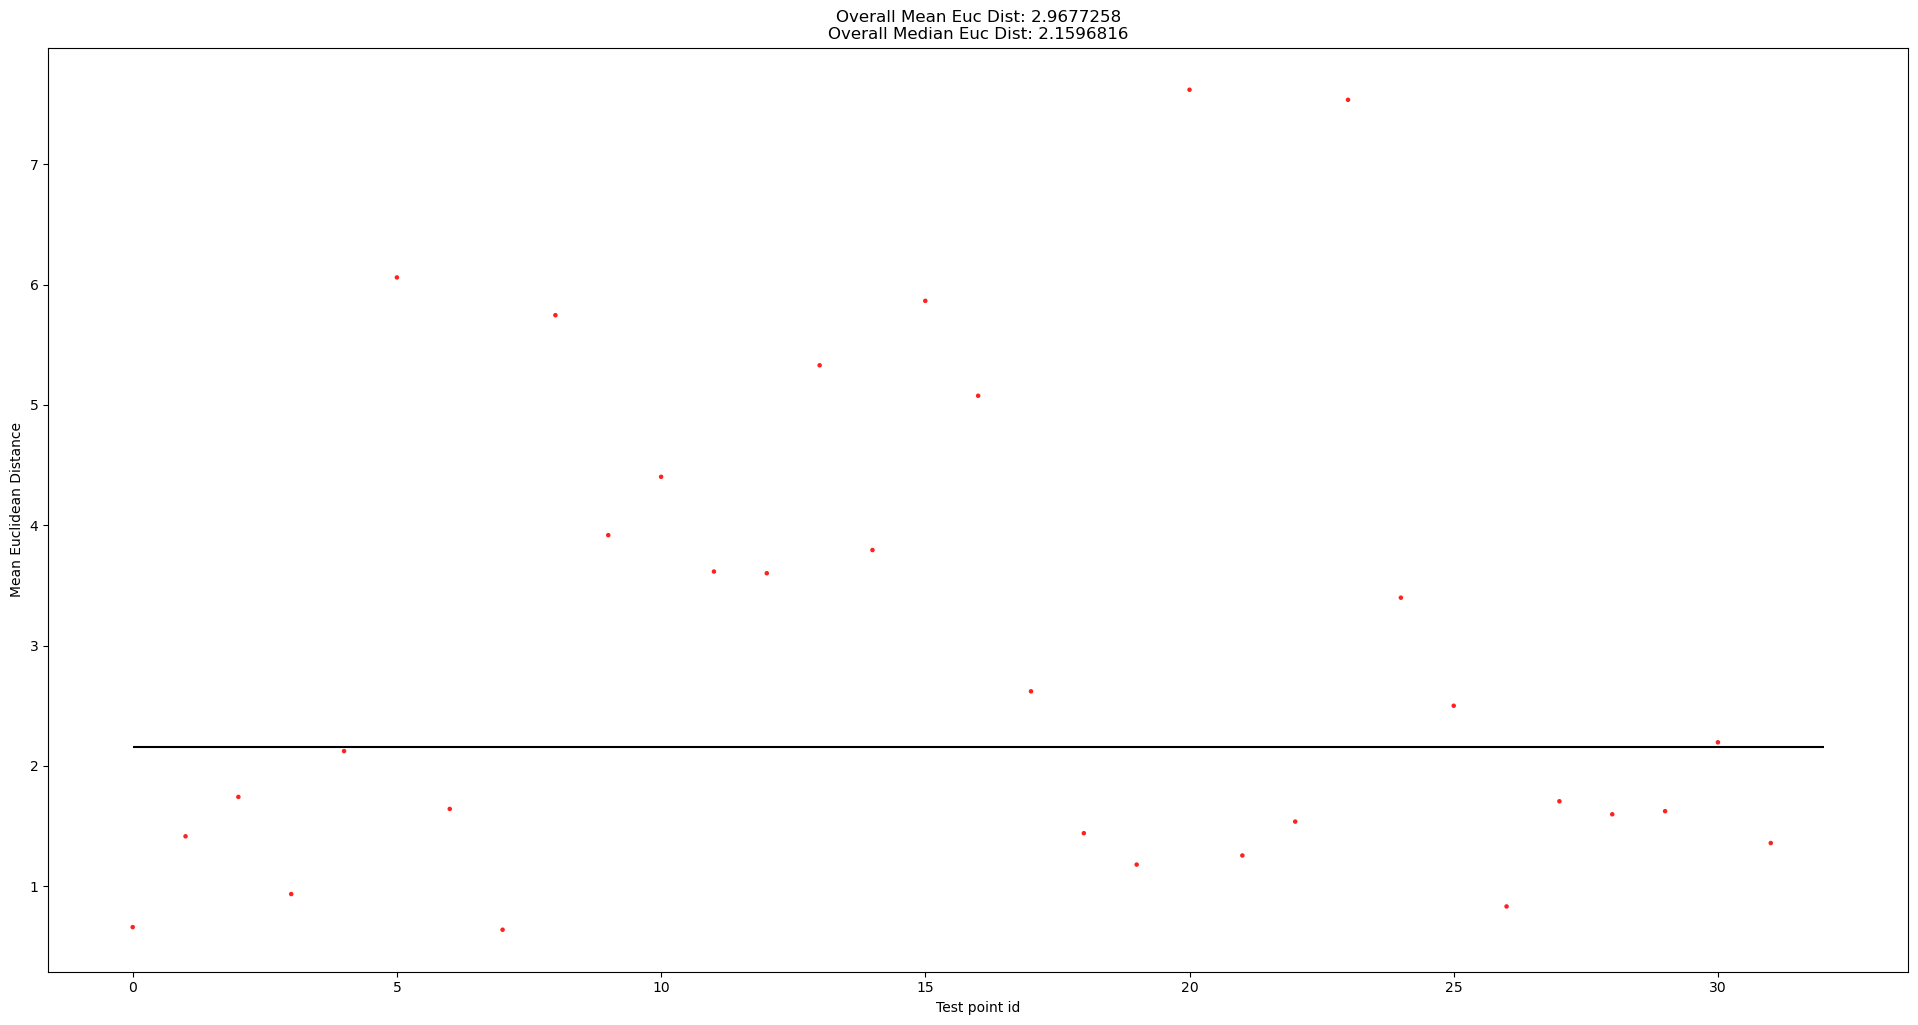

In [23]:
mean_errs = []
cols = []
c = get_colors(len(total_test))
random.shuffle(c)
for idx, i in enumerate(total_test):
    mean_errs.extend(total_test[i][0])
    cols.extend([c[idx] for j in range(len(total_test[i][0]))])
    
plt.figure(figsize=(24, 12))
plt.title("Overall Mean Euc Dist: "+str(np.mean(mean_errs)) + "\nOverall Median Euc Dist: "+str(np.median(mean_errs)))
plt.scatter([i for i in range(len(mean_errs))], mean_errs,c=cols, s=5)
plt.hlines(y=np.mean(mean_errs), xmin=0, xmax=len(mean_errs), color='white')
plt.hlines(y=np.median(mean_errs), xmin=0, xmax=len(mean_errs), color='black')
plt.xlabel('Test point id')
plt.ylabel('Mean Euclidean Distance')


### Random Test

device:  iPhone 6
id:  0
Num files:  32
Sample:


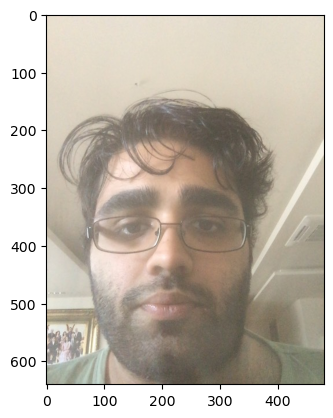

In [14]:
idx = 0
meta = json.load(open(glob(files[idx].replace('images', 'meta')+"*.json")[0]))
print("device: ", meta['device'])
print("id: ", idx)
print("Num files: ", len(glob(files[idx]+"*.jpg")))
print("Sample:")
plt.imshow(plt.imread(glob(files[idx]+"*.jpg")[0]))

I'm testing how the image data is transformed in the gazetrack_dataset method below. Goal is to figure out the scaling factor and zero-point which we need to use to quantize the values. 

In [9]:
from torchvision.transforms import Normalize, Resize, Compose, ToTensor, RandomCrop

In [10]:
def get_transforms(size=(128, 128), normalized=True): 
    list_transforms = []
    if normalized: 
        list_transforms = [
            Resize((size[0],size[1])),
            ToTensor(),
            Normalize(mean=(0.3741, 0.4076, 0.5425), std=(0.02, 0.02, 0.02)),
        ]
    else: 
        list_transforms = [
            Resize((size[0],size[1])),
            ToTensor(),
        ]
    list_trfms = Compose(list_transforms)
    return list_trfms

In [11]:
f = './converted_00002/train/images/'
files = glob(f+"*.jpg")
image = Image.open(files[0])
pixels = np.asarray(image)
fname = files[0]
with open(files[0].replace('.jpg','.json').replace('images', 'meta')) as f:
    meta = json.load(f)
w, h = image.size

screen_w, screen_h = meta['screen_w'], meta['screen_h']
lx, ly, lw, lh = meta['leye_x'], meta['leye_y'], meta['leye_w'], meta['leye_h']
rx, ry, rw, rh = meta['reye_x'], meta['reye_y'], meta['reye_w'], meta['reye_h']

kps = [meta['leye_x1']/w, meta['leye_y1']/h, meta['leye_x2']/w, meta['leye_y2']/h, 
        meta['reye_x1']/w, meta['reye_y1']/h, meta['reye_x2']/w, meta['reye_y2']/h]

l_eye = image.crop((max(0, lx), max(0, ly), max(0, lx+lw), max(0, ly+lh)))
r_eye = image.crop((max(0, rx), max(0, ry), max(0, rx+rw), max(0, ry+rh)))

l_eye_transpose = l_eye.transpose(Image.FLIP_LEFT_RIGHT)

unnormalized_transform = get_transforms(normalized=False)
normalized_transform = get_transforms()

unnormalized_l_eye_tensor = unnormalized_transform(l_eye)
unnormalized_r_eye_tensor = unnormalized_transform(r_eye)
normalized_l_eye_tensor = normalized_transform(l_eye)
normalized_r_eye_tensor = normalized_transform(r_eye)

/var/folders/7z/3v8k89lj23951gywfb99fknc0000gn/T/ipykernel_83158/3877365349.py:20: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  l_eye_transpose = l_eye.transpose(Image.FLIP_LEFT_RIGHT)


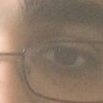

In [71]:
l_eye

In [18]:
tensor = normalized_l_eye_tensor[2]
maxval, minval = -100000000, 100000000
for i in range(len(tensor)): 
    for j in range(len(tensor[i])): 
        maxval = max(maxval, tensor[i][j])
        minval = min(minval, tensor[i][j])
print(maxval, " ", minval)

tensor(11.1103)   tensor(-12.6152)


### Output Sample Data for App Use (Testing Mobile Inference)

In [34]:
import numpy as np
import pandas as pd

i = 0
for j in test_dataloader: 
    i += 1
    leye, reye, kps, target = j[1].to(dev), j[2].to(dev), j[3].to(dev), j[4].to(dev)
    
    leye_np = leye.numpy()
    reye_np = reye.numpy()
    kps_np = kps.numpy()
    target_np = target.numpy()
    
    # ============ leye & reye =============
    # red channel
    leye_df1 = pd.DataFrame(leye_np[0][0])
    leye_df1.to_csv("00002_sample_output/leye1.csv", index=False, header = False)

    reye_df1 = pd.DataFrame(reye_np[0][0])
    reye_df1.to_csv("00002_sample_output/reye1.csv", index=False, header = False)

    # green channel
    leye_df2 = pd.DataFrame(leye_np[0][1])
    leye_df2.to_csv("00002_sample_output/leye2.csv", index=False, header = False)

    reye_df2 = pd.DataFrame(reye_np[0][1])
    reye_df2.to_csv("00002_sample_output/reye2.csv", index=False, header = False)

    # blue channel
    leye_df3 = pd.DataFrame(leye_np[0][2])
    leye_df3.to_csv("00002_sample_output/leye3.csv", index=False, header = False)

    reye_df3 = pd.DataFrame(reye_np[0][2])
    reye_df3.to_csv("00002_sample_output/reye3.csv", index=False, header = False)

    # ============ kps =============
    # the 11 values form a column in the dataframe - is that an issue? 
    kps_df = pd.DataFrame(kps_np[0])
    kps_df.to_csv("00002_sample_output/kps.csv", index=False, header = False)

    # ============ target =============
    # the 2 values form a column in the df - is that an issue?
    target_df = pd.DataFrame(target_np[0])
    target_df.to_csv("00002_sample_output/target.csv", index = False, header = False)

    torch.set_printoptions(threshold=-1)
    print("leye: ", leye[0][0])
    print("reye: ", reye[0])
    print("kps: ", kps[0])
    print("target: ", target[0])
    if (i == 1): break

leye:  tensor([[ 7.3734,  7.1774,  6.9813,  ..., 24.8244, 25.0205, 25.2166],
        [ 6.9813,  6.5891,  6.7852,  ..., 25.0205, 25.0205, 25.0205],
        [ 6.7852,  6.3930,  6.7852,  ..., 25.0205, 25.0205, 24.6283],
        ...,
        [ 7.1774,  7.1774,  6.9813,  ..., 27.3734, 27.9617, 28.3538],
        [ 6.1970,  6.0009,  5.8048,  ..., 27.5695, 27.9617, 28.3538],
        [ 6.9813,  6.3930,  6.1970,  ..., 27.7656, 28.1577, 28.7460]])
reye:  tensor([[[ 8.7460,  8.5499,  9.1381,  ...,  9.1381,  9.1381,  8.3538],
         [ 8.9421,  9.1381,  9.7264,  ...,  8.9421,  8.9421,  8.3538],
         [ 9.1381,  9.7264, 10.3146,  ...,  8.3538,  8.3538,  8.1577],
         ...,
         [29.9225, 29.5303, 29.3342,  ..., 22.4715, 22.4715, 22.6675],
         [29.9225, 29.7264, 29.3342,  ..., 22.2754, 22.0793, 21.8832],
         [29.7264, 29.5303, 29.1381,  ..., 22.0793, 21.8832, 21.6872]],

        [[ 5.6984,  5.5024,  6.0906,  ...,  4.7180,  4.7180,  3.9337],
         [ 5.6984,  5.8945,  6.6788,  .

In [54]:
preds, gt = [], []
ctr = 1
f = files[idx]
fs = glob(f+"*.jpg")
test_dataset = gazetrack_dataset(f, phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=256, num_workers=10, pin_memory=False, shuffle=False,)

if(torch.cuda.is_available()):
    dev = torch.device('cuda:0')
else:
    dev = torch.device('cpu')

preds, gt = [], []
for j in test_dataloader:
    # leye, reye, kps, target = j[1].cuda(), j[2].cuda(), j[3].cuda(), j[4].cuda()
    leye, reye, kps, target = j[1].to(dev), j[2].to(dev), j[3].to(dev), j[4].to(dev)
    print("leye: ", leye[0])
    print("reye: ", reye.shape)
    print("kps: ", kps.shape)
    print("target: ", target.shape)

    with torch.no_grad():
        pred = model(leye, reye, kps)
    pred = pred.detach().cpu().numpy()
    preds.extend(pred)  

    gt.extend(target.detach().cpu().numpy())

preds = np.array(preds)
pts = np.unique(gt, axis=0)

c = get_colors(len(pts))
random.shuffle(c)

gt = np.array(gt)
dist = euc(preds, gt)
print("Mean Euclidean Distance: ", dist.mean())
plot_pts(f, gt, preds, pts, c, "Mean euc: "+str(dist.mean()))

Num files for test = 32
leye:  torch.Size([32, 3, 128, 128])
reye:  torch.Size([32, 3, 128, 128])
kps:  torch.Size([32, 11])
target:  torch.Size([32, 2])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x11 and 8x128)